In [2]:
!pip install numpy pandas nltk scipy sklearn matplotlib

In [3]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import time
import codecs
import csv
from sklearn import feature_extraction
import collections 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

from scipy.spatial import distance
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')
#nltk.download('punkt')


In [13]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.utils import tokenize

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
## Helper functions to clean and normalize input text

# Take in a string and remove stopwords
# RETURN: array of string tokens
def rem_stop_words(example_sent):
    
    example_sent = str(example_sent)
    stop_words = set(stopwords.words('english')) 

    word_tokens = word_tokenize(example_sent) 
  
  
    filtered_sentence = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
  
    return(filtered_sentence) 

# Take in a string and remove punctuation, repeat lines, etc.
# RETURN: string (cleaned up)
def cleaner(text):
    
    text = re.sub('NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO PROTECT CONFIDENTIALITY','', text)
    text = re.sub('<BR/>',' ', text)
    text = text.lower()
    text = re.sub('[****]','',text)
    
    text = re.sub('[/%#;:!,.<>\'?\"()-\[\]]',' ',text)
    text = re.sub('[0-9*]','',text)

    text = re.sub(r'(?:^| )\w(?:$| )', ' ', text)
    
    a = nltk.pos_tag(tokenize_only(text))
    a = pd.DataFrame(a)
    a = a[a[1] == 'NN']
    text = ' '.join(a[0])
    
    return(text)

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if(stemmer.stem(token) not in rem_words):
                filtered_tokens.append(token)
    return filtered_tokens

def tokenize_and_stem(text):
    
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    stems = [e for e in stems if e not in rem_words ]
    return stems

def dt(x):
    x = x.split('/')
    return(x[0])

def dt2(x):
    x = x.split('/')
    return(x[2])


In [5]:
## Load in the data here and group by Year & Month

df = pd.read_csv("data_subset.csv")

year =  list(map(dt2, df['inspection_date']))
month = list(map(dt, df['inspection_date']))
df['Year']  = year
df['Month'] = month

stemmer = SnowballStemmer("english")

In [6]:
print(df.head(n=5))

   Unnamed: 0                                   facility_name facility_id  \
0      259576                                FORT SCOTT MANOR      175384   
1      189057  THE PINNACLE REHABILITATION AND NURSING CENTER      366010   
2      330759                    WESTGATE GARDENS CARE CENTER      555208   
3       19116    MEADOWVIEW NURSING AND REHABILITATION CENTER      315358   
4      287104                               EAGLE CLIFF MANOR      275123   

                     address        city state    zip inspection_date  \
0         736 HEYLMAN STREET  FORT SCOTT    KS  66701      12/05/2014   
1          330 SOUTHWEST AVE   TALLMADGE    OH  44278      07/27/2017   
2        4525 W. TULARE AVE.     VISALIA    CA  93277      10/04/2018   
3            235 DOLPHIN AVE  NORTHFIELD    NJ   8225      04/26/2019   
4  1415 YELLOWSTONE RIVER RD    BILLINGS    MT  59105      10/20/2016   

   deficiency_tag scope_severity  complaint  standard eventid  \
0             280              D 

In [8]:
temp = df["inspection_text"]

In [9]:
print(temp[0])

**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO PROTECT CONFIDENTIALITY** <BR/>The facility identified a census of 38 residents with 22 residents selected for review. Based on observation record review and interview the facility failed to review and revise the plan of care to implement timely and effective interventions for 2 residents (#7 and #6) with repeated falls.<BR/>Findings included:<BR/>- Resident #7's current diagnoses obtained from the Physician order [REDACTED]. heart output is low and the body becomes congested with fluid) and an admission date of [DATE].<BR/>The annual MDS (minimum data set) dated on 4/16/14 revealed a BIMS (Brief interview of mental status) score of 14 indicating the resident is cognitively intact. The resident required extensive assistance of 1 staff member with transfers walking and toileting. The resident had experienced previous falls.<BR/>The functional status CAAs (care area assessment) dated on 4/16/14 revealed the resident required minimum to maximu

In [11]:
rem_words_1 = "survey,nurse,cited,am,pm,resident,residents,she,not,review,facility,state,have,year,employee,reported,management,"
rem_words_2 = "he,staff,interview,care,date,reveal,record,be,month,document,physician,lpn,na,code,description,previous,hospital,m,"
rem_words_3 = "observation,stated,assessment,don,mds,gna,cna,pa,cm,medical,names,order,status,immediately,redacted,condition,plan,"
rem_words_4 = "administrative,note,time,indicated,incident,redirected,director,uses,include,inr,rn,investigation,asked,following,"
rem_words_5 = "provided,alleged,failed,identified,said,ei,ri,parking,assist,every,get,"
rem_words_6 = "room,left,mm,hg,adl,xl,day,mg,mar,knows,prn,look,ard,give,ml,also,ted,made,non,bims,pasrr," # 7/13 update
num_alphas  = "one,two,three,four,five,six,seven,eight,nine,ten,"
rem_words = rem_words_1 + rem_words_2 + rem_words_3 + rem_words_4 + rem_words_5 + rem_words_6 + num_alphas
rem_words = rem_words.split(',')
rem_words = [stemmer.stem(t) for t in rem_words]

In [12]:
temp_new = []
for k in temp: temp_new.append(' '.join(rem_stop_words(cleaner(k))))

In [16]:
print(temp_new[0])

census heart output body fluid admission brief score extensive member caas area minimum maximum living mobility ability fall area risk alarm safety bed chair exacerbation gait strengthening education balance posture correction careplan alarm bed hall laying floor tear wrist fall worksheet slid floor wrist fall alarm recliner bed alarm bed alarm present recliner alarm present recliner alarm present recliner call light alarm alarm careplan alarm recliner bed alarm bed alarm policy procedure fall prevention bed function battery life placement fall safety risk team implemention mobility brief mental cognition person wheelchair mobility pain history antianxiety anticoagulant bed bed restraint brief mental cognition person wheelchair mobility history anticoagulant period area loss dementia evidence reassessment analysis self deficit bed alarm safety alarm wheelchair safety post fall floor matt maintain night post injury location safety monitor lobby awake intervention monitor area alarm orie

In [24]:
healthvec= [nltk.word_tokenize(temp_new) for temp_new in temp_new]

In [25]:
model = Word2Vec(healthvec)

In [32]:
v= model.wv['flu']
print(v)

[ 0.14088084  0.5259309   1.0217128   1.0731452   1.0002866  -1.8690296
  1.5859156   0.6171387  -0.01523997 -0.16381583  0.6714344  -0.42687556
  0.26924548  1.8902638  -0.555292   -1.5705222   0.93162656 -1.2613094
  0.45529056  1.0620731  -0.6085049  -0.8445281  -0.47851124  0.8498028
 -0.27222708  0.88558906 -1.3618026  -2.0215023  -0.13635442  0.967086
  0.44115278  0.7757614   0.45061776 -1.8584236  -0.6871046  -0.02109622
  0.37511674  0.71856993  1.7747941  -3.004394   -1.0897307  -0.07706393
  2.1391163   0.7838036   0.4229111  -0.56375515 -1.0508822  -1.6901125
  0.25945124 -1.8874823  -1.2237914  -2.2592638   0.9473969  -0.9350366
  0.7944156  -0.415623    0.62720597 -0.42215657 -1.6648446   1.4442213
  0.17498074  0.8670608   0.2987453  -0.463589    0.49007663 -0.07771213
 -1.7415564  -1.4963723  -0.00712725  1.9573216   1.8223482   2.0946443
  1.7745502   0.3679458   2.5068448   0.9032201  -1.4128693  -0.20691074
 -0.11695873  0.8343547   0.16327897 -2.4388142   0.30953106

In [28]:
model.wv.most_similar('flu', topn=10)

[('influenza', 0.871087372303009),
 ('pneumovac', 0.7161561846733093),
 ('vaccine', 0.6776870489120483),
 ('droplet', 0.6688663959503174),
 ('vaccination', 0.6675280928611755),
 ('ili', 0.666110634803772),
 ('previnar', 0.666003942489624),
 ('ppv', 0.6630711555480957),
 ('pnuemonia', 0.6575309634208679),
 ('prevnar', 0.6530660390853882)]

In [29]:
distance.cosine(model.wv['flu'] , model.wv['influenza'])

0.12891262769699097

In [7]:
def gen_cluster_topwords(tdf, wq, nc):

    THE_TEXT_DF = tdf.copy()
    WORD_QUANTITY = wq
    NUM_CLUSTERS = nc
    
    clust_results = pd.DataFrame({'x' : [] ,'y' : [],'label' : [],'state' : [],'deficiency_tag' : [],'Region' : [],'UID' : [],'scope_severity': [],'Year':[],'Month':[]})
    clust_words = pd.DataFrame({'Cluster' : [] ,'Top_5_Words' : [],'deficiency_tags' : [],'Region' : [],'scope_severity' : [],'Year':[],'Month':[]})
    muns = list(map(str, THE_TEXT_DF.Month.unique()))
    km_scores = []
    
    for j in muns:
        print("Month:", j)
        texts = THE_TEXT_DF[THE_TEXT_DF['Month'] == j]
        texts_1 = texts.inspection_text
        texts_new= []
        
        for k in texts_1: texts_new.append(' '.join(rem_stop_words(cleaner(k))))
        
        synopses = texts_new
        totalvocab_stemmed = []
        totalvocab_tokenized = []
        
        for k in synopses:
            allwords_stemmed = tokenize_and_stem(k) 
            totalvocab_stemmed.extend(allwords_stemmed) 
            allwords_tokenized = tokenize_only(k)
            totalvocab_tokenized.extend(allwords_tokenized)
            
        vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
          
            ''
        tfidf_vectorizer = TfidfVectorizer(use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,1))
        tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses
        
        terms = tfidf_vectorizer.get_feature_names()
        dist = 1 - cosine_similarity(tfidf_matrix)
        km = KMeans(n_clusters = NUM_CLUSTERS)
        km.fit(tfidf_matrix)
        km_scores.append(km.score(tfidf_matrix))
        clusters = km.labels_.tolist()
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]
        
        cluster_words = pd.DataFrame(data = [],columns = ['Cluster','Top_5_Words'])
        for k in range(NUM_CLUSTERS):
            for ind in order_centroids[k, :WORD_QUANTITY]: 
                cluster_words = cluster_words.append({'Cluster': k , 'Top_5_Words':vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0]}, ignore_index=True )
        
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
        
        pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
        pos = pos
        xs, ys = pos[:, 0], pos[:, 1]
        
        a = lambda x: str(x)
        clusters = list(map(a,clusters))
        
        #create data frame that has the result of the MDS plus the cluster numbers and titles
        a  = lambda x: str(x)
        clusters = list(map(a,clusters))
        
        #create data frame that has the result of the MDS plus the cluster numbers and titles
        df1 = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
        df1['state'] = list(texts['state'])
        df1['deficiency_tag'] = list(texts['deficiency_tag'])
        df1['Region'] = list(texts['Region'])
        df1['UID'] = list(texts['UID'])
        df1['scope_severity'] = list(texts['scope_severity'])
        df1['Year'] = list(texts['Year'])
        df1['Month'] = list(texts['Month'])
        cluster_words['Year'] = np.repeat(np.unique(texts.Year), len(cluster_words))
        cluster_words['Month'] = np.repeat(np.unique(texts.Month), len(cluster_words))
        clust_results = pd.concat([clust_results, df1])
        #print('before:', clust_words.shape)
        clust_words = pd.concat([clust_words, cluster_words])
        #print('after:', clust_words.shape)
        
    # Cut out NaN values
    clust_words = clust_words[['Cluster','Top_5_Words','Year','Month']]
    # Convert Month values from STR to INT
    clust_words['Month'] = clust_words['Month'].astype(int)
    gensim{clust_words} = pd.concat([clust_results, df1])
    dirpath = pd.read_csv(theFil)
    
    return clust_words

In [16]:
# df = pd.read_csv("s3://osapeast/home/data/csv_w_id_table/csv_w_id")

## Open whole CSV file
#theFile = 'sample_survey.cssv'
#theFile = 'textreg1-dtag_880_689_812_656-NoLabel.csv'
DIRPATH = 'notebook'
theFile = 'glove.6B.50d.txt'

glove = pd.read_csv(theFile, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
words = pd.read_csv('word2vec_data.txt',index_col=0,quoting=csv.QUOTE_NONE)

#clust_words = pd.read_csv('s3a://osapeast/home/data/ClustWordsPerMonth_reg4_2017.csv')
#clust_words_r3 = pd.read_csv('s3a://osapeast/home/data/ClustWordsPerMonth_reg3_2017.csv')


In [18]:
glove

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,,,,,,,,,,,,,,,,,,,,,
the,0.418000,0.249680,-0.41242,0.121700,0.34527,-0.044457,-0.496880,-0.178620,-0.000660,-0.656600,...,-0.298710,-0.157490,-0.347580,-0.045637,-0.442510,0.187850,0.002785,-0.184110,-0.115140,-0.785810
",",0.013441,0.236820,-0.16899,0.409510,0.63812,0.477090,-0.428520,-0.556410,-0.364000,-0.239380,...,-0.080262,0.630030,0.321110,-0.467650,0.227860,0.360340,-0.378180,-0.566570,0.044691,0.303920
.,0.151640,0.301770,-0.16763,0.176840,0.31719,0.339730,-0.434780,-0.310860,-0.449990,-0.294860,...,-0.000064,0.068987,0.087939,-0.102850,-0.139310,0.223140,-0.080803,-0.356520,0.016413,0.102160
of,0.708530,0.570880,-0.47160,0.180480,0.54449,0.726030,0.181570,-0.523930,0.103810,-0.175660,...,-0.347270,0.284830,0.075693,-0.062178,-0.389880,0.229020,-0.216170,-0.225620,-0.093918,-0.803750
to,0.680470,-0.039263,0.30186,-0.177920,0.42962,0.032246,-0.413760,0.132280,-0.298470,-0.085253,...,-0.094375,0.018324,0.210480,-0.030880,-0.197220,0.082279,-0.094340,-0.073297,-0.064699,-0.260440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chanty,0.232040,0.025672,-0.70699,-0.045465,0.13989,-0.628070,0.726250,0.341080,0.446140,0.163290,...,-0.095526,-0.296050,0.385670,0.136840,0.593310,-0.694860,0.124100,-0.180690,-0.258300,-0.039673
kronik,-0.609210,-0.672180,0.23521,-0.111950,-0.46094,-0.007462,0.255780,0.856320,0.055977,-0.237920,...,0.672050,-0.598220,-0.202590,0.392430,0.028873,0.030003,-0.106170,-0.114110,-0.249010,-0.120260
rolonda,-0.511810,0.058706,1.09130,-0.551630,-0.10249,-0.126500,0.995030,0.079711,-0.162460,0.564880,...,0.024747,0.200920,-1.085100,-0.136260,0.350520,-0.858910,0.067858,-0.250030,-1.125000,1.586300


In [20]:
glove.loc['the']

1     0.418000
2     0.249680
3    -0.412420
4     0.121700
5     0.345270
6    -0.044457
7    -0.496880
8    -0.178620
9    -0.000660
10   -0.656600
11    0.278430
12   -0.147670
13   -0.556770
14    0.146580
15   -0.009510
16    0.011658
17    0.102040
18   -0.127920
19   -0.844300
20   -0.121810
21   -0.016801
22   -0.332790
23   -0.155200
24   -0.231310
25   -0.191810
26   -1.882300
27   -0.767460
28    0.099051
29   -0.421250
30   -0.195260
31    4.007100
32   -0.185940
33   -0.522870
34   -0.316810
35    0.000592
36    0.007445
37    0.177780
38   -0.158970
39    0.012041
40   -0.054223
41   -0.298710
42   -0.157490
43   -0.347580
44   -0.045637
45   -0.442510
46    0.187850
47    0.002785
48   -0.184110
49   -0.115140
50   -0.785810
Name: the, dtype: float64

In [10]:

# Read the top_word list from a file
#clust_words_1 = pd.read_csv("s3://osapeast/home/data/ClustWordsPerMonth_reg5a_2018.csv")
#clust_words_1 = pd.read_csv("s3://osapeast/home/data/ClustWordsPerMonth_reg3_2017.csv")
#clust_words_1 = pd.read_csv("s3://osapeast/home/data/ClustWordsPerMonth_reg4_2017.csv")
dfk = pd.read_csv("ClustWordsPerMonth_all.csv")
print(dfk.shape)
print(dfk.head(n=10))


(66185, 6)
   Unnamed: 0  Cluster Top_5_Words  Year  Month region
0           0        0        pain  2017      1      1
1           1        0    surveyor  2017      1      1
2           2        0        unit  2017      1      1
3           3        0      policy  2017      1      1
4           4        0         bed  2017      1      1
5           5        0   admission  2017      1      1
6           6        0          mg  2017      1      1
7           7        0        fall  2017      1      1
8           8        0        food  2017      1      1
9           9        0         dns  2017      1      1


In [11]:


## Weighted Mean Calculation
def getMonthWeightedMeans(clust_words, numWords, keyword):
    month_min = np.min(clust_words['Month'].unique())
    month_max = np.max(clust_words['Month'].unique())
    monthMeans = np.zeros((50,len(clust_words['Month'].unique())))
    wordWeightsDF = pd.DataFrame()
    DEBUG = 0
    for month in range(month_min, month_max+1):
    #for month in range(month_min, 2):
        month_words = clust_words.loc[clust_words['Month'] == month]['Top_5_Words'].values
        monthMean = np.zeros((50,)) #words.loc[month_words.iloc[0]]
        monthWeightSum = 0.0
        count = 0
        wordWeights = {}
        if DEBUG: print('Similar words to:', keyword, "for the month:", month)
        for word in month_words:
            try:
                sim_val = distance.cosine(model.wv[word] , model.wv[keyword]))
                if sim_val <= 0.35:
                    if DEBUG: print("   *", word, str(1-sim_val)[0:5])
                    count = count + 1
                    sim_val = (1 - sim_val) * 5
                else:
                    if DEBUG: print("    ", word, str(1-sim_val)[0:5])
                
                monthWeightSum = monthWeightSum + (1 - sim_val)
                wordWeights[word] = 1 - sim_val
                monthMean = monthMean + (1 - sim_val) * model.wv[word]
                
            except KeyError:
                if DEBUG==2: print('Word not in embedding dict:', word)
                continue
    return monthMeans, wordWeightsDF

# give vector of means, return the difference in distance
def autodist(month_means):
    dists = []
    for i in range(0,month_means.shape[1]-1):
        #simi_distances.append(distance.cosine(monthMeans[:,i]/100, monthMeans[:,i+1]/100))
        dists.append(distance.euclidean(month_means[:,i], month_means[:,i+1]))
    return dists

## Show the word differences per month
def indexed_difference(a1,a2):
    sa = {'a1':list(set(a1).difference(set(a2))), 'a2':list(set(a2).difference(set(a1)))}
    return sa

Starting processing on YEAR: 2018 REGION: 1
Calculating Weighted Means...
Generating Month-Month Word Differences...
Total Runtime (mins): 2.7791602969169618


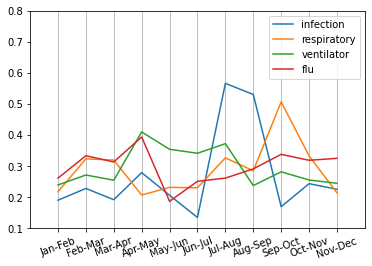

In [12]:

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun' ,'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months_merge = [months[i]+"-"+months[i+1] for i in range(0, len(months)-1)]

DEBUG = 1
NUM_WORDS = 200
for YEAR in [2018]: #dfk['Year'].unique():
    df_y = dfk[dfk['Year'] == YEAR]
    df_y = df_y.astype({'region': str})
    for REGION in df_y['region'].unique()[0]:
        
        start_time = time.time()
        
        clust_words_1 = df_y[df_y['region'] == REGION]

        fname_data = 'TrendLine_reg' + REGION + "_" + str(YEAR) + ".csv"
        fname_words = 'TrendWords_reg' + REGION + "_" + str(YEAR) + ".csv"
        
        print("Starting processing on YEAR:", YEAR, "REGION:", REGION)
        #print(fname_data)
        #print(fname_words)
        
        t_range = clust_words_1['Month'].unique()
        
        
        print("Calculating Weighted Means...")
        ## Get back the weighted mean matrix        
        A,_ = getMonthWeightedMeans(clust_words_1, NUM_WORDS, 'infection')
        B,_ = getMonthWeightedMeans(clust_words_1, NUM_WORDS, 'respiratory')
        C,_ = getMonthWeightedMeans(clust_words_1, NUM_WORDS, 'ventilator')
        D,_ = getMonthWeightedMeans(clust_words_1, NUM_WORDS, 'flu')

        ## Get the month-month difference
        dist_wm1 = autodist(A)
        dist_wm2 = autodist(B)
        dist_wm3 = autodist(C)
        dist_wm4 = autodist(D)

        ## Scale range by minmax
        AA = dist_wm1/np.linalg.norm(dist_wm1)
        BB = dist_wm2/np.linalg.norm(dist_wm2)
        CC = dist_wm3/np.linalg.norm(dist_wm3)
        DD = dist_wm4/np.linalg.norm(dist_wm4)
        
        ## Plot (for testing)
        if DEBUG:
            plt.plot(t_range[:-1], AA, t_range[:-1], BB, t_range[:-1], CC, t_range[:-1], DD)
            plt.axis([0,12, 0.1,0.8])
            plt.xticks(t_range[:-1], months_merge, rotation=20)
            plt.legend(['infection', 'respiratory', 'ventilator', 'flu'])
            plt.grid(True, axis='x')
        
        
        ## Generate Month-Month word differences
        print("Generating Month-Month Word Differences...")
        WordsMonthArr_M1 = []
        WordsMonthArr_M2 = []
        for i in range(0, len(t_range)-1):
            cw = [clust_words_1[clust_words_1['Month'] == i]['Top_5_Words'].values, clust_words_1[clust_words_1['Month'] == i+1]['Top_5_Words'].values]
            cwd = indexed_difference(cw[0], cw[1])
            WordsMonthArr_M1.append(str(cwd['a1']))
            WordsMonthArr_M2.append(str(cwd['a2']))

        FRAMELEN = len(AA)
        dt1 = {
            'Month_1':clust_words_1.Month.unique()[:-1],
            'Month_2':clust_words_1.Month.unique()[1:],
            'Year':np.repeat(clust_words_1.Year.unique()[0], FRAMELEN),
            'Region':np.repeat(REGION, FRAMELEN),
            'Infection':AA,
            'Respiratory':BB,
            'Ventilator':CC,
            'Flu':DD,
            'Words_Month1':WordsMonthArr_M1,
            'Words_Month2': WordsMonthArr_M2
        }

        dft1 = pd.DataFrame(data = dt1)
        SaveFile = 0
        if SaveFile:
            print("Saving file:", fname_data)
            dft1.to_csv(fname_data, index=False)
    
        print("Total Runtime (mins):", (time.time() - start_time)/60)

<h2>Get the intersection of the top-words per month</h2>

In [ ]:
## Generate Month-Month word differences
#print("Generating Month-Month Word Differences...")
#print(clust_words_1.columns.values)
#print(clust_words_1['Year'].unique(), clust_words_1['region'].unique())
WordsMonthArr_M1 = []
WordsMonthArr_M2 = []
WordsMonthArr_M = []
for i in range(0, len(t_range)-1):
    cw = [clust_words_1[clust_words_1['Month'] == i]['Top_5_Words'].values, clust_words_1[clust_words_1['Month'] == i+1]['Top_5_Words'].values]
    cwd = indexed_difference(cw[0], cw[1])
    print(len(cwd['a1']), len(cwd['a2']))
    j,k = 0,0
    #while j < 200-len(cwd['a1']): cwd['a1'].append('')
    #while k < 200-len(cwd['a2']): cwd['a2'].append('')
    #print(len(cwd['a1']), len(cwd['a2']))
    WordsMonthArr_M1.append(str(cwd['a1']))
    WordsMonthArr_M2.append(str(cwd['a2']))
#k1 = [s.replace('\'','').replace('[','').replace(' ','').replace(']','') for s in k1]
#print(WordsMonthArr_M1)
#print(WordsMonthArr_M2)
#print(WordsMonthArr_M1[2])
#print(WordsMonthArr_M1[3])
"""
print('MAR-APR')
print([WordsMonthArr_M1[2] + WordsMonthArr_M2[2]])
print('APR-MAY')
print(WordsMonthArr_M1[3] + WordsMonthArr_M2[3])
print('MAR-APR/APR-MAY')
k=indexed_difference([WordsMonthArr_M1[2] + WordsMonthArr_M2[2]], [WordsMonthArr_M1[3] + WordsMonthArr_M2[3]])
print("MAR-APR **>",k['a1'])
print("APR-MAY **>",k['a2'])
#print('MAY-JUN')
#print(WordsMonthArr_M1[4] + WordsMonthArr_M2[4])
#print('JUN-JUL')
#print(WordsMonthArr_M1[5] + WordsMonthArr_M2[5])
print(len(cwd['a1']), len(cwd['a2']))
"""

In [ ]:
print("***> ",[WordsMonthArr_M1[2] + WordsMonthArr_M2[2]])
print("***> ",[WordsMonthArr_M1[3] + WordsMonthArr_M2[3]])

In [ ]:

t_range = clust_words_1['Month'].unique()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun' ,'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months_merge = [months[i]+"-"+months[i+1] for i in range(0, len(months)-1)]
##months_merge.append("Dec-Jan")

plt.figure(1)
plt.xlabel('2018 Month')
plt.ylabel('Respiratory Infection Potential')
plt.title('Region 3, dtag = 880, 689')

#plt.plot(t_range[:-1], dist_1, t_range[:-1], dist_2)
plt.plot(t_range[:-1], dist_wm, t_range[:-1], dist_1)
plt.grid(True, axis='x')
plt.axis([0,12, 0.2,0.45])

# Label the x,y values for R3
for label, x, y in zip(dist_wm, t_range[:-1], dist_wm):
    plt.annotate(str(label*100)[0:6]+'%', xy=(x, y), xytext=(0, 0), textcoords="offset points")

"""
# Label the x,y values for R4
for label, x, y in zip(dist_2, t_range[:-1], dist_2):
    plt.annotate(str(label*100)[0:6]+'%', xy=(x, y), xytext=(0, 0), textcoords="offset points")
"""

###
plt.legend(['Tag 880', 'Tag 689'])
#plt.xticks(t_range, months_merge, rotation=20)
#plt.show()

"""
plt.figure(2)
plt.xlabel('2017 Month')
plt.ylabel('Respiratory Infection Potential')
plt.title('Regions 3 and 4 Trend')

plt.plot(t_range, dist_r3, t_range, dist_r4)
plt.grid(True, axis='x')
plt.axis([0,12, 0.25,0.5])

# Label the x,y values for R3
for label, x, y in zip(dist_r3, t_range, dist_r3):
    plt.annotate(str(label*100)[0:6]+'%', xy=(x, y), xytext=(0, 0), textcoords="offset points")

# Label the x,y values for R4
for label, x, y in zip(dist_r4, t_range, dist_r4):
    plt.annotate(str(label*100)[0:6]+'%', xy=(x, y), xytext=(0, 0), textcoords="offset points")

###
plt.legend(['Region 3', 'Region 4'])
plt.xticks(t_range, ['Jan-Feb', 'Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-Jun', 'Jun-Jul', 'Jul-Aug', 'Aug-Sep', 'Sep-Oct', 'Oct-Nov', 'Nov-Dec', 'Dec-Jan'],
rotation=20)
plt.show()
"""


In [ ]:
%pyspark

month_min = np.min(clust_words_1['Month'].unique())
month_max = np.max(clust_words_1['Month'].unique())

# print(distance.euclidean(monthMeans_r3[:,month_max-2]/100, monthMeans_r3[:,month_max-1]/100))
# print(distance.euclidean(monthMeans_r3[:,2]/100, anomaly_mean[:,1]))
# print(distance.euclidean(monthMeans_r3[:,month_max-1]/100, anomaly_mean[:,0]))
# print(distance.euclidean(monthMeans_r3[:,month_max-1]/100, anomaly_mean[:,1]))
# print(distance.euclidean(anomaly_mean[:,0], anomaly_mean[:,1]))

# #dist_r3.append(distance.euclidean(monthMeans_r3[:,month_max-1]/100, anomaly_mean[:,1]))
# #dist_r4.append(distance.euclidean(monthMeans_r4[:,month_max-1]/100, anomaly_mean[:,1]))

# print(np.var(dist_r3[:-1]))
# print(np.var(dist_r4[:-1]))

#print(np.var(dist_1), np.var(dist_2))

def indexed_difference(a1,a2):
    sa = {'a1':list(set(a1).difference(set(a2))), 'a2':list(set(a2).difference(set(a1)))}
    return sa

#print(distance.euclidean(monthMeans_1[:,3], monthMeans_1[:,4]))

#cw_1_45 = [clust_words_1[clust_words_1['Month'] == 4]['Top_5_Words'].values, clust_words_1[clust_words_1['Month'] == 5]['Top_5_Words'].values]

#cw_2_45 = [clust_words_2[clust_words_2['Month'] == 4]['Top_5_Words'].values, clust_words_2[clust_words_2['Month'] == 5]['Top_5_Words'].values]
#cw_2_1112=[clust_words_2[clust_words_2['Month'] == 11]['Top_5_Words'].values, clust_words_2[clust_words_2['Month'] == 12]['Top_5_Words'].values]

#cw_12_1 = [clust_words_1[clust_words_1['Month'] == 1]['Top_5_Words'].values, clust_words_2[clust_words_2['Month'] == 1]['Top_5_Words'].values]

cw_2_45 = [clust_words_2[clust_words_2['Month'] == 4]['Top_5_Words'].values, clust_words_2[clust_words_2['Month'] == 5]['Top_5_Words'].values]
cw_2_78 = [clust_words_2[clust_words_2['Month'] == 7]['Top_5_Words'].values, clust_words_2[clust_words_2['Month'] == 8]['Top_5_Words'].values]

#for i in range(0,monthMeans_1.shape[1]): print(distance.euclidean(monthMeans_1[:,i], monthMeans_2[:,i]))
    
#print(distance.cosine(words.loc['hand'], words.loc['hands']))
#for i in range(0, 200): print(cw_1_45[0][i], '\t', cw_1_45[1][i])
#print(set(cw_1_45[0]).union(set(cw_1_45[1])))
#print(set(cw_1_45[0]).intersection(set(cw_1_45[1])))
#print(set(cw_2_1112[0]).intersection(set(cw_2_1112[1])))
#print(indexed_difference(cw_2_78[0],cw_2_78[1]))


In [ ]:
def gen_wordVectors(a,getmeans=0):
    vectors_1 = []
    vectors_2 = []
    vec1_mean = 0
    vec2_mean = 0
    for word in a['a1']:
        try:
            w = words.loc[word].values
            vec1_mean = vec1_mean + w
            vectors_1.append(w)
        except KeyError:
            continue
    for word in a['a2']:
        try:
            w = words.loc[word].values
            vec2_mean = vec2_mean + w
            vectors_2.append(w)
        except KeyError:
            continue

    vec1_mean = vec1_mean / len(a['a1'])
    vec2_mean = vec2_mean / len(a['a2'])
    
    if getmeans == 1:
        return vectors_1, vectors_2, vec1_mean, vec2_mean
    else:
        return vectors_1, vectors_2

"""
tsne = TSNE(n_components=2, random_state=0)

#cw_2_diff = indexed_difference(cw_2_1112[0],cw_2_1112[1])
#cw_2_diff = indexed_difference(cw_12_1[0], cw_12_1[1])
#cw_2_diff = indexed_difference(cw_2_45[0],cw_2_45[1])
"""

cw_2_diff = indexed_difference(cw_2_78[0],cw_2_78[1])
v1,v2 = gen_wordVectors(cw_2_diff)
Y_1 = tsne.fit_transform(v1)
Y_2 = tsne.fit_transform(v2)

#plt.figure(1)
plt.subplot(2,1,1)
plt.plot(Y_1[:,0], Y_1[:,1], Y_2[:,0], Y_2[:,1], marker='o', linestyle='', ms=10)
my1 = [np.mean(Y_1[:,0]), np.mean(Y_1[:,1])]
my2 = [np.mean(Y_2[:,0]), np.mean(Y_2[:,1])]
plt.plot(my1[0], my1[1], marker='o', linestyle='', ms=20)
plt.plot(my2[0], my2[1], marker='o', linestyle='', ms=20)
plt.annotate(str(my1[0])+","+str(my1[1]), xy=(x,y), xytext=(0,0), textcoords="offset points")
plt.annotate(str(my2[0])+","+str(my2[1]), xy=(x,y), xytext=(0,0), textcoords="offset points")
#plt.title('Region=3, dtag=689, Word Cluster Nov-Dec')
#plt.legend(['November', 'December'])
plt.grid(True)


cw_2_diff = indexed_difference(cw_2_45[0], cw_2_45[1])
v1,v2 = gen_wordVectors(cw_2_diff)
Y_1 = tsne.fit_transform(v1)
Y_2 = tsne.fit_transform(v2)

plt.subplot(2,1,2)
plt.plot(Y_1[:,0], Y_1[:,1], Y_2[:,0], Y_2[:,1], marker='o', linestyle='', ms=10)
my1 = [np.mean(Y_1[:,0]), np.mean(Y_1[:,1])]
my2 = [np.mean(Y_2[:,0]), np.mean(Y_2[:,1])]
plt.plot(my1[0], my1[1], marker='o', linestyle='', ms=20)
plt.plot(my2[0], my2[1], marker='o', linestyle='', ms=20)
plt.annotate(str(my1[0])+","+str(my1[1]), xy=(x,y), xytext=(0,0), textcoords="offset points")
plt.annotate(str(my2[0])+","+str(my2[1]), xy=(x,y), xytext=(0,0), textcoords="offset points")
plt.grid(True)